# Representações e Fingerprints

## O que são Fingerprints?

Os fingerprints são descritores moleculares que codificam a funcionalidades/ fragmentos de uma molécula na forma de um dígito binário (0 ou 1). Desse modo, podemos usar os fingerprints moleculares para analisar moléculas químicas e usá-las em modelos de aprendizagem de máquina. Um bit está ligado (vale 1) quando um determinado fragmento está presente na estrutura molecular.

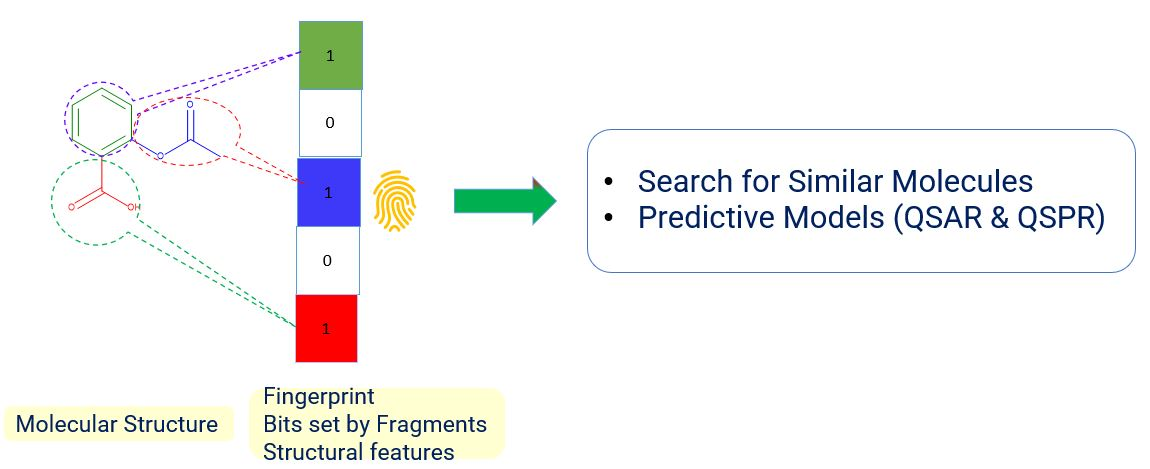

Neste notebook, serão abordados os seguintes tópicos:

- Como gerar Morgan Fingerprints usando a `RDKit`
- Convertendo vetores `RDKit` em arrays do `Numpy`
- Análise exploratória de dados de moléculas químicas (descritores)

### Importando Bibliotecas

In [1]:
!pip3 install rdkit tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 17.3 MB/s eta 0:00:00


In [12]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
#---------------------- RDKit packages
from rdkit.Chem import AllChem
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import PandasTools

#------------------- progress bar
from tqdm import tqdm

#------------------- hide warning
import warnings
warnings.filterwarnings('ignore')

## Carregando o Dataset

Usaremos um [dataset](https://www.sciencedirect.com/science/article/pii/S2451929420300851) criado para predição de reações químicas. Desse modo, iremos carregar os dados usando a biblioteca `Pandas`

In [3]:
# carregando o dataset
dataset = pd.read_csv('https://raw.githubusercontent.com/gashawmg/HOMO-LUMO-Enegry-gap-Prediction/master/Orbital_Energies_input_data.csv')

# adicionando a representação em rdkit da estrutura molecular
PandasTools.AddMoleculeColumnToFrame(dataset,'SMILES', 'Structure')

# visualizando as 10 primeira linhas
dataset.head(10)

,SMILES,Energygap,Structure
0,Cc1ccc(cc1)C(F)(F)F,197.749421,<rdkit.Chem.rdchem.Mol object at 0x7e7130f1b140>
1,OC(=O)CCCCl,247.493942,<rdkit.Chem.rdchem.Mol object at 0x7e7130f1b1b0>
2,CC(C)(Oc1ccc(CCNC(=O)c2ccc(Cl)cc2)cc1)C(=O)O,164.712327,<rdkit.Chem.rdchem.Mol object at 0x7e7130f1b220>
3,Nc1ccc(Cl)c(Cl)c1,169.027707,<rdkit.Chem.rdchem.Mol object at 0x7e7130f1b290>
4,C[C@@H](CCO)CCC=C(C)C,209.569808,<rdkit.Chem.rdchem.Mol object at 0x7e7130f1b300>
5,OC(C=C)C=C,210.979194,<rdkit.Chem.rdchem.Mol object at 0x7e7130f1b370>
6,O=N(=O)c1ccc(Cl)c(c1)N(=O)=O,168.833179,<rdkit.Chem.rdchem.Mol object at 0x7e7130f1b3e0>
7,O=CC1CCCCC1,213.451579,<rdkit.Chem.rdchem.Mol object at 0x7e7130f1b450>
8,COc1ccc(cc1)C#C,171.191985,<rdkit.Chem.rdchem.Mol object at 0x7e7130f1b4c0>
9,Brc1cncnc1,188.344944,<rdkit.Chem.rdchem.Mol object at 0x7e7130f1b530>


Note que as moléculas já estão na representação SMILES.

Ignoraremos a coluna `Energygap`, já que ela não agrega informação útil para este exercício.

## Gerando Fingerprints

Nesta seção, iremos gerar os Morgan Fingerprints, também conhecidos como Fingerprints Circulares ou Extended Conectivity Fingerprints(ECFP), e são descritores moleculares do tipo circular, amplamente utilizados em quimioinformática para representar a estrutura de uma molécula em um formato numérico processável por computadores.

Eles funcionam mapeando o ambiente químico de cada átomo em raios sucessivos (definidos pelo parâmetro radius), onde cada fragmento circular encontrado é convertido em um identificador único através de um algoritmo de hashing.

O seu principal uso é na triagem virtual e no aprendizado de máquina, permitindo calcular a similaridade estrutural entre compostos (geralmente via coeficiente de Tanimoto) ou servir como variáveis de entrada (features) para modelos preditivos de atividade biológica, toxicidade e propriedades físico-químicas.

### Como funcionam

O algoritmo implementado pela `RDKit` atribui um identificador inteiro inicial a cada átomo (com base em suas propriedades, como o elemento químico e o seu grau de conectividade). Em seguida, ele atualiza iterativamente esses identificadores observando os vizinhos de cada átomo dentro de um raio especificado.

- **Raio 0:** Apenas o próprio átomo.

- **Raio 1:** O átomo e seus vizinhos imediatos.

- **Raio 2:** O átomo, seus vizinhos e os vizinhos deles (aproximadamente equivalente ao ECFP4).

Cada ambiente químico único descoberto durante essas iterações é convertido (via hashing) em um bit específico dentro de um vetor de comprimento fixo (geralmente 1024 ou 2048 bits).

In [4]:
# cria o gerador
mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)

onbits = {}
mf = mfpgen.GetFingerprint(dataset.Structure[0])
print(np.array(mf))

[0 0 0 ... 0 0 0]


In [5]:
# função para gerar fingerprints de todas as moleculas do dataset
def generate_fpts(data, mfpgen):
    # lista que irá armazenar todos os Morgan fingerprints
    Mfpts = []

    for mol in tqdm(data):
        # calcula os Morgan fingerprints e insere-os na lista
        mfpt = mfpgen.GetFingerprint(mol)
        Mfpts.append(mfpt)

    return np.array(Mfpts)

In [6]:
mfpts = generate_fpts(dataset.Structure[:200], mfpgen)

100%|██████████| 200/200 [00:00<00:00, 27630.46it/s]


## Comparando moléculas

Uma das formas de comparar moléculas químicas é usando o coeficiente de Tanimoto. Nesta seção, usaremos as moléculas da Aspirina e do Ácido Salicílico para demonstrar como a comparação entre elas pode ser feita.

$$T(A, B) = \frac{N_c}{N_a + N_b - N_c}$$

Na fórmula acima,

- $T(A, B)$: Coeficiente de similaridade de Tanimoto entre as moléculas A e B.
- $N_a$: Número de bits ativos (ligados) no fingerprint da molécula A.
- $N_b$: Número de bits ativos (ligados) no fingerprint da molécula B.
- $N_c$: Número de bits comuns (interseção) ativos em ambas as moléculas simultaneamente.

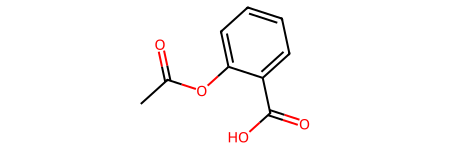

In [7]:
# estrutura molecular 2D da aspirina
aspirin = AllChem.MolFromSmiles('O=C(C)Oc1ccccc1C(=O)O')
aspirin

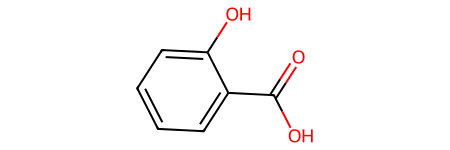

In [8]:
# estrutura molecular 2D do ácido salicílico
salicylic_acid = AllChem.MolFromSmiles('O=C(O)c1ccccc1O')
salicylic_acid

In [9]:
# gerando fingerprints
aspirin_fp =  mfpgen.GetFingerprint(aspirin)
salicylic_acid_fp =  mfpgen.GetFingerprint(salicylic_acid)

A função DataStructs.FingerprintSimilarity compara dois vetores de bits (fingerprints) para quantificar o quão estruturalmente próximos eles são.

In [10]:
# calculando o coeficiente de Tanimoto usando RDKit
DataStructs.FingerprintSimilarity(aspirin_fp, salicylic_acid_fp, metric=DataStructs.TanimotoSimilarity)

0.4482758620689655

O valor de saída é um número decimal entre 0 (totalmente diferentes) e 1 (idênticos ou muito similares).

**Interpretação Química:** Embora a Aspirina seja derivada do Ácido Salicílico, o valor de ~0.45 indica uma similaridade moderada. Isso ocorre porque o grupo acetil adicional na Aspirina altera significativamente os ambientes químicos circulares capturados pelo raio do Morgan Fingerprint.

**Contexto:** Em triagem virtual (virtual screening), um valor acima de 0.7 ou 0.8 é geralmente considerado o patamar para identificar moléculas com alta probabilidade de terem a mesma atividade biológica.

## Atividade Prática

**Tarefa:** Identificar compostos similares ao Ibuprofeno.

**Carregar e visualizar compostos**

1. Use o dataset utilizado no notebook (variável `dataset`);
2. Selecione 50 moléculas aleatórias;
3. Crie uma molécula de referência: Ibuprofeno (SMILES: CC(C)Cc1ccc(cc1)C(C)C(=O)O).

**Calcular similaridades**

1. Gere Morgan Fingerprints (radius=2, fpSize=2048) para todas as moléculas
2. Calcule o coeficiente de Tanimoto entre o Ibuprofeno e cada molécula do conjunto
3. Identifique as 5 moléculas mais similares

**Visualização**

1. Crie um gráfico de barras mostrando a similaridade das 10 moléculas mais próximas;
2. Desenhe as estruturas 2D das 5 moléculas mais similares ao lado do Ibuprofeno.

#Resolução Atividade Prática

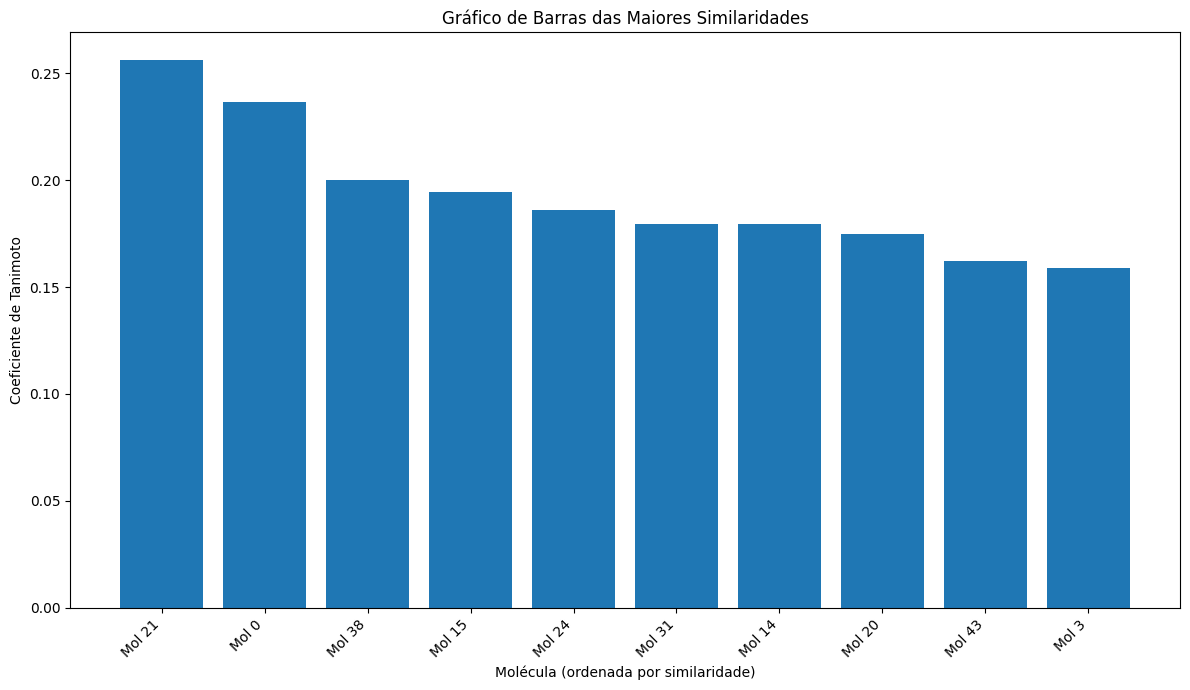

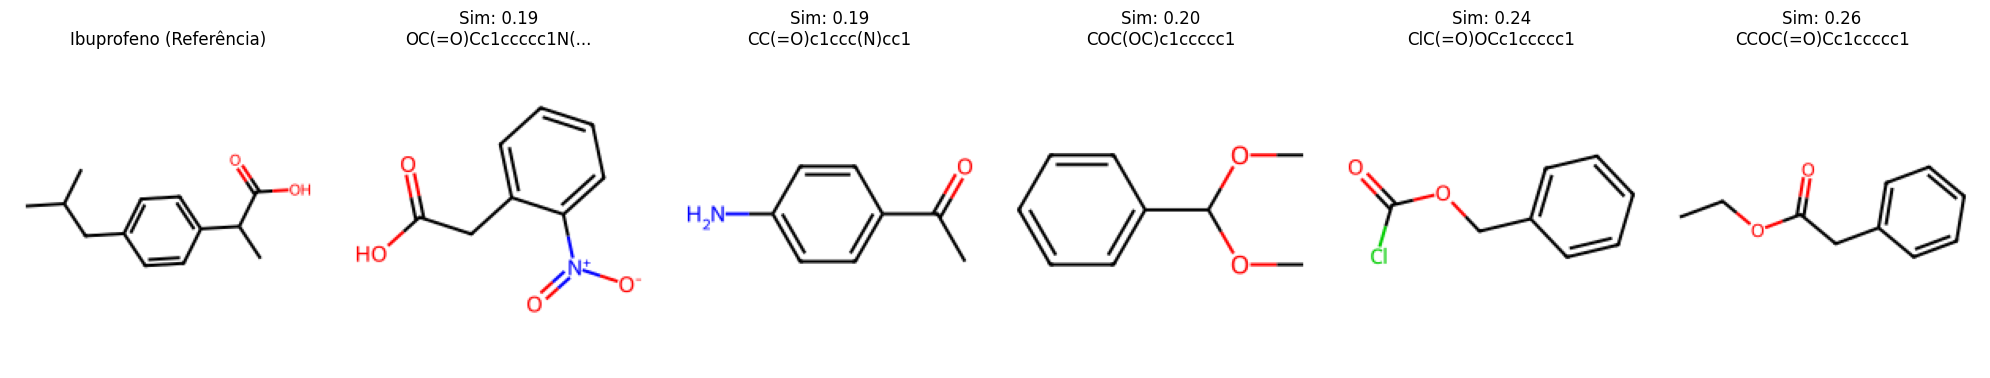

In [13]:
#carregar dataset como "dataset"
dataset = pd.read_csv('https://raw.githubusercontent.com/gashawmg/HOMO-LUMO-Enegry-gap-Prediction/master/Orbital_Energies_input_data.csv')

# adicionando a representação em rdkit da estrutura molecular novamente
PandasTools.AddMoleculeColumnToFrame(dataset,'SMILES', 'Structure')

#selecionar 50 moleculas aleatórias
random_dataset = dataset.sample(n=50, random_state=42)

#criar molécula de referência: Ibuprofeno
ibuprofen = AllChem.MolFromSmiles('CC(C)Cc1ccc(cc1)C(C)C(=O)O')
fgp_ibuprofen = mfpgen.GetFingerprint(ibuprofen)

#calcular o coeficiente de Tanimoto entre o ibuprofeno e cada molécula do conjunto
similarity_scores = []
for mol in random_dataset.Structure:
    # mol já é um objeto RDKit Mol graças ao AddMoleculeColumnToFrame
    mol_fp = mfpgen.GetFingerprint(mol)

    similarity = DataStructs.FingerprintSimilarity(fgp_ibuprofen, mol_fp, metric=DataStructs.TanimotoSimilarity)
    similarity_scores.append(similarity)

#identificar as 5 moléculas mais similares
top_5_indices = np.argsort(similarity_scores)[-5:]

# Exibir apenas as 10 maiores similaridades (se houver, o gráfico de barras anterior era pra 10 maiores)
# E o código para identificar as 5 moléculas mais similares é top_5_indices
# Então vou ajustar o gráfico para mostrar as 5 maiores também, ou se o usuário quiser 10, podemos mudar.
num_display_scores = min(len(similarity_scores), 10) # Display up to 10 if available
sorted_scores = np.sort(similarity_scores)[::-1]

plt.figure(figsize=(12, 7))
plt.bar(range(num_display_scores), sorted_scores[:num_display_scores])
plt.xlabel('Molécula (ordenada por similaridade)')
plt.ylabel('Coeficiente de Tanimoto')
plt.title('Gráfico de Barras das Maiores Similaridades')
plt.xticks(range(num_display_scores), [f'Mol {idx}' for idx in np.argsort(similarity_scores)[-num_display_scores:]], rotation=45, ha='right')
plt.tight_layout()
plt.show()


#Desenho das 5 estruturas mais parecidas com o ibuprofeno
plt.figure(figsize=(20, 10)) # Increased figure width to accommodate longer titles

# Desenhar o ibuprofeno como referência
plt.subplot(1, 6, 1) # 1 linha, 6 colunas, 1ª posição
ibuprofen_img = Draw.MolToImage(ibuprofen, size=(200, 200))
plt.imshow(ibuprofen_img)
plt.title('Ibuprofeno (Referência)')
plt.axis('off')

for i, idx in enumerate(top_5_indices):
    plt.subplot(1, 6, i + 2) # As moléculas similares começam da 2ª posição
    mol = random_dataset.iloc[idx].Structure
    mol_img = Draw.MolToImage(mol, size=(200, 200)) # Gera a imagem PIL
    plt.imshow(mol_img) # Exibe a imagem PIL usando imshow

    # Get the SMILES string for the title
    smiles = random_dataset.iloc[idx].SMILES
    # Truncate SMILES if too long, or adjust figure size
    title_smiles = smiles if len(smiles) < 20 else smiles[:17] + '...'

    plt.title(f'Sim: {similarity_scores[idx]:.2f}\n{title_smiles}')
    plt.axis('off')

plt.tight_layout()
plt.show()


## Referências

- https://github.com/gashawmg/Molecular-fingerprints/blob/main/Calculating%20molecular%20fingerprints%20available%20in%20RDkit%20.ipynb
- https://www.kaggle.com/code/towardsentropy/fingerprint-tips-and-tricks